### Here i kept the the latent dimension constant as 10. and kept trying different # of layers and different dimensions.

| # of H layers |     Dims     | Latent_dim | Total params | Loss in 5 epochs |
|:-------------:|:------------:|:----------:|:------------:|:----------------:|
|       1       |      64      |     10     |   103,204    |     104.5480     |
|       1       |     128      |     10     |   205,604    |     98.6375      |
|       2       |    64*64     |     10     |   111,524    |     101.3859     |
|       2       |    128*64    |     10     |   220,196    |     96.3071      |
|     **2**     | **128*128**  |   **10**   | **238,628**  |   **94.2977**    |
|       3       |  64\*64*64   |     10     |   119,844    |     102.6280     |
|       3       |  128\*64*64  |     10     |   228,516    |     97.0993      |
|       3       | 128\*128*64  |     10     |   253,220    |     95.1069      |
|       3       | 128\*128*128 |     10     |   271,652    |     93.6840      |

### As you can see, the best loss is in 2 layers (128*128)(in bold).
##### Note: 3 layers with 128\*128\*128 has better loss but the total params is also more so since the difference isn't big so i will use the 2 layers (128*128)

### Then let's try different latent dimensions.

| # of H layers |    Dims     | Latent_dim | Total params | Loss in 5 epochs |
|:-------------:|:-----------:|:----------:|:------------:|:----------------:|
|       2       |   128*128   |     10     |   238,628    |     94.2977      |
|       2       |   128*128   |     5      |   236,698    |     114.9283     |
|       2       |   128*128   |     15     |   240,558    |     86.3964      |
|       2       |   128*128   |     20     |   242,488    |     81.6003      |
|     **2**     | **128*128** |   **25**   | **244,418**  |   **79.9020**    |
|     **2**     | **128*128** |   **27**   | **245,190**  |   **79.4050**    |
|     **2**     | **128*128** |   **30**   | **246,348**  |   **79.4013**    |
|       2       |   128*128   |     40     |   250,208    |     78.2735      |
|       2       |   128*128   |     50     |   254,068    |     78.3197      |

### As you can see, the 3 layers (in bold) has the best loss. so i will use the the one with 27 latent dimension.

In [1]:
import keras
from keras import layers
import numpy as np

original_dim = 28 * 28
intermediate_dim = 128
deep_dim = 128
# deeper_dim = 64
latent_dim = 27

inputs = keras.Input(shape=(original_dim,))

h = layers.Dense(intermediate_dim, activation='relu')(inputs)
deep_h = layers.Dense(deep_dim, activation='relu')(h)
# deeper_h = layers.Dense(deeper_dim, activation='relu')(deep_h)

z_mean = layers.Dense(latent_dim)(deep_h)
z_log_sigma = layers.Dense(latent_dim)(deep_h)

print("Mean and sigma have the same shape which is {}".format(z_mean.shape))

Mean and sigma have the same shape which is (None, 27)


<!-- ![](ML1533-image003.jpg) -->
<img src="ML1533-image003.jpg" width="700" height="350">

### Here we have reached the point where we have a mean and std of the latent vector.
### So we need a function to generate the latent vector using the mean and std.

In [2]:
from keras import backend as K

def sampling(args):
    z_mean, z_log_sigma = args
    epsilon = K.random_normal(shape=(K.shape(z_mean)[0], latent_dim),
                              mean=0., stddev=0.1)
    return z_mean + K.exp(z_log_sigma) * epsilon

### Here we use lambda to use pass the mean and std to the function "sampling" which is used to generate the latent vector.

In [3]:
z = layers.Lambda(sampling)([z_mean, z_log_sigma])

In [4]:
# Create encoder
encoder = keras.Model(inputs, [z_mean, z_log_sigma, z], name='encoder')

# Create decoder

latent_inputs = keras.Input(shape=(latent_dim,), name='z_sampling')

# deeper_x = layers.Dense(deeper_dim, activation='relu')(latent_inputs)
deep_x = layers.Dense(deep_dim, activation='relu')(latent_inputs)
x = layers.Dense(intermediate_dim, activation='relu')(deep_x)

outputs = layers.Dense(original_dim, activation='sigmoid')(x)

decoder = keras.Model(latent_inputs, outputs, name='decoder')

### We still need to connect the model
Remmember:

        encoder(inputs)[0]  => z_mean
        encoder(inputs)[1]  => z_log_var
        encoder(inputs)[2]  => is the z
### So what we need to do is
1. Get the inputs
2. Pass it to the encoder and get the z_mean, z_log_var, z
3. Pass the z to the decoder and get the output.

        decoder(encoder(inputs)[2])
4. Create the full vae model

In [5]:
# instantiate VAE model
outputs = decoder(encoder(inputs)[2])
vae = keras.Model(inputs, outputs, name='vae_mlp')
vae.summary()

Model: "vae_mlp"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 784)]             0         
                                                                 
 encoder (Functional)        [(None, 27),              123958    
                              (None, 27),                        
                              (None, 27)]                        
                                                                 
 decoder (Functional)        (None, 784)               121232    
                                                                 
Total params: 245,190
Trainable params: 245,190
Non-trainable params: 0
_________________________________________________________________


### Creating the loss function

In [6]:
reconstruction_loss = keras.losses.binary_crossentropy(inputs, outputs)
reconstruction_loss *= original_dim
kl_loss = 1 + z_log_sigma - K.square(z_mean) - K.exp(z_log_sigma)
kl_loss = K.sum(kl_loss, axis=-1)
kl_loss *= -0.5
vae_loss = K.mean(reconstruction_loss + kl_loss)
vae.add_loss(vae_loss)

In [7]:
vae.compile(optimizer='adam')

In [8]:
from keras.datasets import mnist

(x_train, y_train), (x_test, y_test) = mnist.load_data()

x_train = x_train.astype('float32') / 255.
x_test = x_test.astype('float32') / 255.
x_train = x_train.reshape((len(x_train), np.prod(x_train.shape[1:])))
x_test = x_test.reshape((len(x_test), np.prod(x_test.shape[1:])))

vae.fit(x_train, x_train,
        epochs=50,
        batch_size=32)
        #validation_data=(x_test, x_test))

11501568/11490434 [==============================] - 0s 0us/step
Epoch 1/50
1875/1875 [==============================] - 10s 5ms/step - loss: 127.6598
Epoch 2/50
1875/1875 [==============================] - 9s 5ms/step - loss: 92.6778
Epoch 3/50
1875/1875 [==============================] - 9s 5ms/step - loss: 85.1095
Epoch 4/50
1875/1875 [==============================] - 9s 5ms/step - loss: 81.3389
Epoch 5/50
1875/1875 [==============================] - 9s 5ms/step - loss: 79.2560
Epoch 6/50
1875/1875 [==============================] - 9s 5ms/step - loss: 77.8267
Epoch 7/50
1875/1875 [==============================] - 11s 6ms/step - loss: 76.8211
Epoch 8/50
1875/1875 [==============================] - 10s 6ms/step - loss: 75.9429
Epoch 9/50
1875/1875 [==============================] - 9s 5ms/step - loss: 75.2668
Epoch 10/50
1875/1875 [==============================] - 9s 5ms/step - loss: 74.6739
Epoch 11/50
1875/1875 [==============================] - 9s 5ms/step - loss: 74.1777
Epoch

In [9]:
x_decoded_original = vae.predict(x_train)

### Save model


In [10]:
# vae.save('savedModel',save_format="tf")

INFO:tensorflow:Assets written to: savedModel/assets


### Load model

In [11]:
vae = keras.models.load_model('savedModel')

### Zip & unzip the model to upload later if needed

In [22]:
!zip -r "/content/savedModel.zip" "/content/savedModel"
# !unzip "/content/savedModel.zip" -d "/content/savedModel/"

updating: content/savedModel/ (stored 0%)
  adding: content/savedModel/variables/ (stored 0%)
  adding: content/savedModel/variables/variables.index (deflated 68%)
  adding: content/savedModel/variables/variables.data-00000-of-00001 (deflated 17%)
  adding: content/savedModel/keras_metadata.pb (deflated 94%)
  adding: content/savedModel/saved_model.pb (deflated 89%)
  adding: content/savedModel/assets/ (stored 0%)


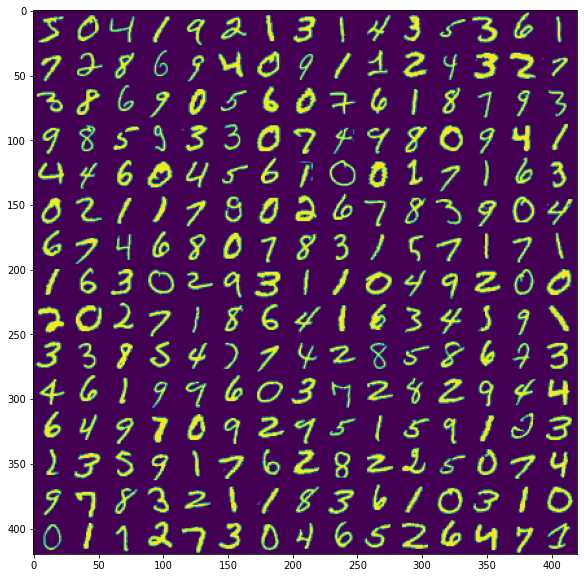

In [12]:
import matplotlib.pyplot as plt
# Display a 2D manifold of the digits
n = 15  # figure with 15x15 digits
digit_size = 28
figure = np.zeros((digit_size * n, digit_size * n))
# We will sample n points within [-15, 15] standard deviations
grid_x = np.linspace(-15, 15, n)
grid_y = np.linspace(-15, 15, n)
k=0
for i, yi in enumerate(grid_x):
    for j, xi in enumerate(grid_y):
        z_sample = np.array([[xi, yi]])
        #x_decoded = decoder.predict(z_sample)
        digit = x_train[k].reshape(digit_size, digit_size)
        k = k +1
        figure[i * digit_size: (i + 1) * digit_size,
               j * digit_size: (j + 1) * digit_size] = digit

plt.figure(figsize=(10, 10))
plt.imshow(figure)
plt.show()

In [13]:
z_zz = encoder.predict(x_train)
print (z_zz[2].shape)
print (z_zz[2][0].shape)

(60000, 27)
(27,)


### Original Data

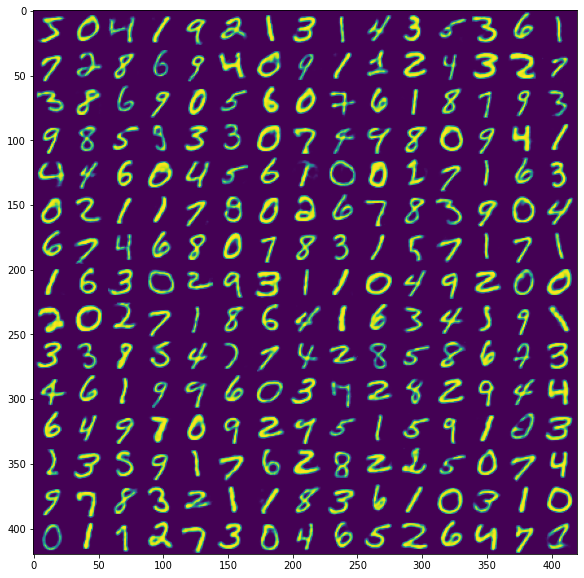

In [14]:
import matplotlib.pyplot as plt

# Display a 2D manifold of the digits
n = 15  # figure with 15x15 digits
digit_size = 28
figure = np.zeros((digit_size * n, digit_size * n))
# We will sample n points within [-15, 15] standard deviations
grid_x = np.linspace(-15, 15, n)
grid_y = np.linspace(-15, 15, n)
k=0
for i, yi in enumerate(grid_x):
    for j, xi in enumerate(grid_y):
        #z_sample = np.array([[xi, yi]])
        #x_decoded = decoder.predict(z_sample)
        
        digit = x_decoded_original[k].reshape(digit_size, digit_size)
        k=k+1
        figure[i * digit_size: (i + 1) * digit_size,
               j * digit_size: (j + 1) * digit_size] = digit

plt.figure(figsize=(10, 10))
plt.imshow(figure)
plt.show()

### Modify the encoded data by two different methods with different values as below:

Try different values for Val1 and figure-out the effect in one of the following methods:

*   Method 1:  `x_decoded = decoder.predict(z_zz[2]+Val)`

*   Method 2:  `x_decoded = decoder.predict(z_zz[0]+z_zz[1] * Val)`

Then figure out the effect of such modification

| Method # | value     | observation |
|--------------|-----------|------------|
| Method 1 | 0.0001     | same as the original       |                
| Method 1      | 0.01  | same as the original      |       
| Method 1      | 0.1  | small loss + smoother than the original      |
| Method 1      | 0.2  |  big loss       |  
| Method 2 | 0.0001     | same as the original       |                
| Method 2      | 0.01  | same as the original      |       
| Method 2      | 0.1  | sharper than the original      |
| Method 2      | 0.2  | sharper than 0.1       | 
| Method 2      | 0.4  | oversharpened + big loss      |            

In [15]:
x_decoded_modified = decoder.predict(z_zz[2]+0.01)
# x_decoded_modified = decoder.predict(z_zz[0]+z_zz[1] * 0.2)

### Modified Data

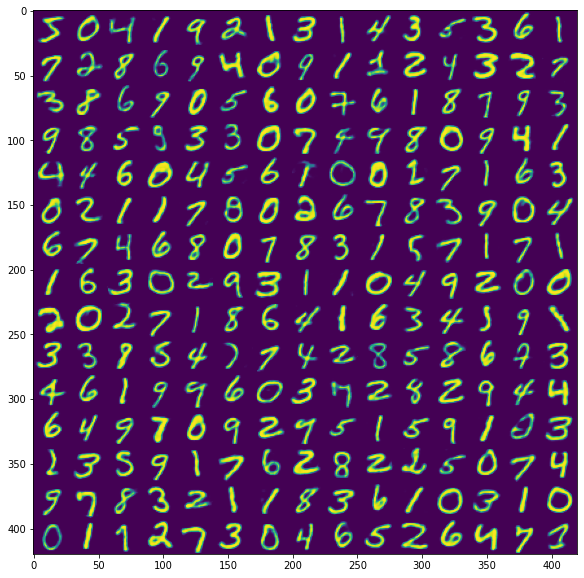

In [16]:
import matplotlib.pyplot as plt
# Display a 2D manifold of the digits
n = 15  # figure with 15x15 digits
digit_size = 28
figure = np.zeros((digit_size * n, digit_size * n))
# We will sample n points within [-15, 15] standard deviations
grid_x = np.linspace(-15, 15, n)
grid_y = np.linspace(-15, 15, n)
k=0
for i, yi in enumerate(grid_x):
    for j, xi in enumerate(grid_y):
        z_sample = np.array([[xi, yi]])
        #x_decoded = decoder.predict(z_sample)
        digit = x_decoded_modified[k].reshape(digit_size, digit_size)
        k = k +1
        figure[i * digit_size: (i + 1) * digit_size,
               j * digit_size: (j + 1) * digit_size] = digit

plt.figure(figsize=(10, 10))
plt.imshow(figure)
f=plt.show()

In [17]:
z_zz[2].shape

(60000, 27)

/usr/local/lib/python3.7/dist-packages/matplotlib/collections.py:885: RuntimeWarning: invalid value encountered in sqrt
  scale = np.sqrt(self._sizes) * dpi / 72.0 * self._factor


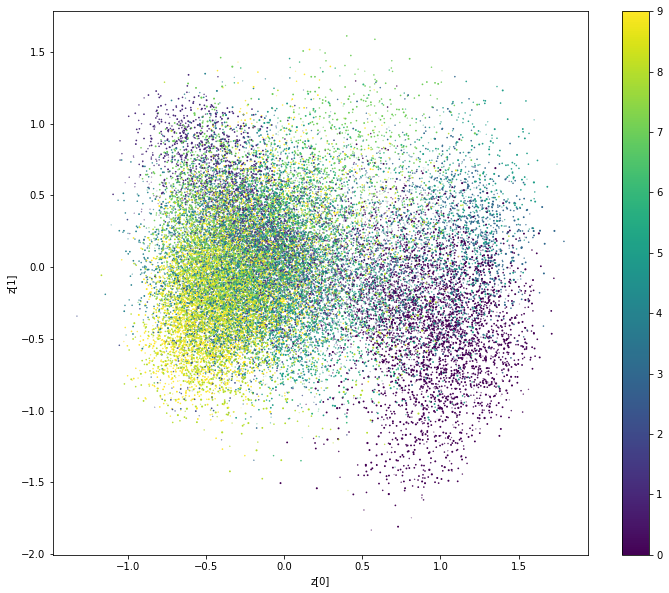

In [18]:
def plot_label_clusters(data, labels):
    # display a 2D plot of the digit classes in the latent space
    z_mean, _, _ = encoder.predict(data)
    plt.figure(figsize=(12, 10))
    plt.scatter(z_mean[:, 0], z_mean[:, 1], z_mean[:, 2], c=labels)
    plt.colorbar()
    plt.xlabel("z[0]")
    plt.ylabel("z[1]")
    plt.show()
plot_label_clusters(x_train, y_train)